# arXiv cs.CL Submission Date Analysis

Before running this notebook, you should make sure you installed all dependencies in requirements.txt and ran download.py.

This analysis is motivated by this tweet: https://twitter.com/lintool/status/928313098305396737. We want to see if indeed arXiv submissions occur a month before the ACL submission deadlines with the new ACL rules. Let's load all the papers metadata (title, authors, submission date) we downloaded.

In [1]:
import pickle

with open('data.pkl', 'rb') as f:
    papers = pickle.load(f)

Great! Now we have all the papers in `papers`. Let's analyze the submission times. A single paper look something like this:

In [2]:
papers[0]

{'authors': [{'name': 'Xu Sun'},
  {'name': 'Xuancheng Ren'},
  {'name': 'Shuming Ma'},
  {'name': 'Bingzhen Wei'},
  {'name': 'Wei Li'},
  {'name': 'Houfeng Wang'}],
 'link': 'http://arxiv.org/abs/1711.06528v1',
 'published': time.struct_time(tm_year=2017, tm_mon=11, tm_mday=17, tm_hour=13, tm_min=36, tm_sec=51, tm_wday=4, tm_yday=321, tm_isdst=0),
 'title': 'Training Simplification and Model Simplification for Deep Learning: A\n  Minimal Effort Back Propagation Method'}

In [3]:
import numpy as np
import pandas as pd

papers_df = pd.DataFrame(papers)

Let's convert the published column to an actual datetime object.

In [4]:
papers_df['published'] = papers_df.apply(lambda r: '-'.join(map(lambda i: str(i).zfill(2), [r.published.tm_year, r.published.tm_mon, r.published.tm_mday])), axis=1).astype('datetime64[D]')

In [5]:
papers_df.head()

,authors,link,published,title
0,"[{'name': 'Xu Sun'}, {'name': 'Xuancheng Ren'}...",http://arxiv.org/abs/1711.06528v1,2017-11-17,Training Simplification and Model Simplificati...
1,"[{'name': 'Anselm Rothe'}, {'name': 'Brenden M...",http://arxiv.org/abs/1711.06351v1,2017-11-16,Question Asking as Program Generation
2,"[{'name': 'Jianbo Chen'}, {'name': 'Yelong She...",http://arxiv.org/abs/1711.06288v1,2017-11-16,Language-Based Image Editing with Recurrent At...
3,[{'name': 'Rajarshee Mitra'}],http://arxiv.org/abs/1711.06238v1,2017-11-16,An Abstractive approach to Question Answering
4,"[{'name': 'Jia-Hong Huang'}, {'name': 'Cuong D...",http://arxiv.org/abs/1711.06232v1,2017-11-16,A Novel Framework for Robustness Analysis of V...


Let's construct a new column that stores the day of submission relative to a conference submission deadline. For example, February 6, 2017 was the submission deadline for ACL 2017. A paper submitted on February 5, 2017 will have a relative day value of -1, and a paper submitted on February 8, 2017 will have a relative day value of 2. We'll also have an additional column for the conference. Note this is a heuristic and doesn't necessarily mean the paper was submitted to the conference.

Here are the submission deadlines of recent ACL and NAACL conferences:

**ACL 2016**:
  * Long paper: March 18, 2016
  * Short paper: Feb 29, 2016

**NAACL 2016**:
  * Long and short paper: January 6, 2016
  
**ACL 2017**:
  * Long and short paper: February 6, 2017

**NAACL 2018**:
  * Long paper: December 15, 2017
  * Short paper: January 10, 2018

In [6]:
submission_deadlines = {
    'acl2016_long': pd.Timestamp('2016-03-18'),
    'acl2016_short': pd.Timestamp('2016-02-29'),
    'naacl2016': pd.Timestamp('2016-01-06'),
    'acl2017': pd.Timestamp('2017-02-06'),
    'naacl2018_long': pd.Timestamp('2017-12-15') - pd.Timedelta('30 days')
}

window = pd.Timedelta('30 days')
submission_deadline_ranges = {k: (v - window, v + window) for (k, v) in submission_deadlines.items()}

def get_relative(row):
    for conf, window_range in submission_deadline_ranges.items():
        if window_range[0] <= row.published <= window_range[1]:
            return row.published - submission_deadlines[conf], conf
    
    return np.nan, np.nan

papers_df['relative'] = papers_df.apply(lambda r: get_relative(r)[0], axis=1)
papers_df['conf'] = papers_df.apply(lambda r: get_relative(r)[1], axis=1)

Now filter the `papers_df` to only contain papers submitted around the conference deadlines.

In [7]:
conf_ddl_papers_df = papers_df[~papers_df.conf.isnull()]
conf_ddl_papers_df.head()

,authors,link,published,title,relative,conf
0,"[{'name': 'Xu Sun'}, {'name': 'Xuancheng Ren'}...",http://arxiv.org/abs/1711.06528v1,2017-11-17,Training Simplification and Model Simplificati...,2 days,naacl2018_long
1,"[{'name': 'Anselm Rothe'}, {'name': 'Brenden M...",http://arxiv.org/abs/1711.06351v1,2017-11-16,Question Asking as Program Generation,1 days,naacl2018_long
2,"[{'name': 'Jianbo Chen'}, {'name': 'Yelong She...",http://arxiv.org/abs/1711.06288v1,2017-11-16,Language-Based Image Editing with Recurrent At...,1 days,naacl2018_long
3,[{'name': 'Rajarshee Mitra'}],http://arxiv.org/abs/1711.06238v1,2017-11-16,An Abstractive approach to Question Answering,1 days,naacl2018_long
4,"[{'name': 'Jia-Hong Huang'}, {'name': 'Cuong D...",http://arxiv.org/abs/1711.06232v1,2017-11-16,A Novel Framework for Robustness Analysis of V...,1 days,naacl2018_long


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

In [9]:
%matplotlib inline

In [10]:
# Grouping by conference and relative days
grouped = conf_ddl_papers_df.groupby([conf_ddl_papers_df.conf, conf_ddl_papers_df.relative], as_index=False).count()
grouped['day'] = grouped.relative.dt.days
grouped = grouped.rename(columns={'title': 'count'})
grouped = grouped[['conf', 'day', 'count']]

In [11]:
grouped.head()

,conf,day,count
0,acl2016_long,-30,4
1,acl2016_long,-29,5
2,acl2016_long,-28,5
3,acl2016_long,-27,1
4,acl2016_long,-25,6


There are some days which have no papers for a certain conference, we need to fill in the missing data.

In [12]:
index_iterables = [grouped.conf.unique(), np.arange(-30, 31, 1)]
multi_index = pd.MultiIndex.from_product(index_iterables, names=['conf', 'day'])
grouped = grouped.set_index(['conf', 'day'])
grouped = grouped.reindex(multi_index, fill_value=0).reset_index()

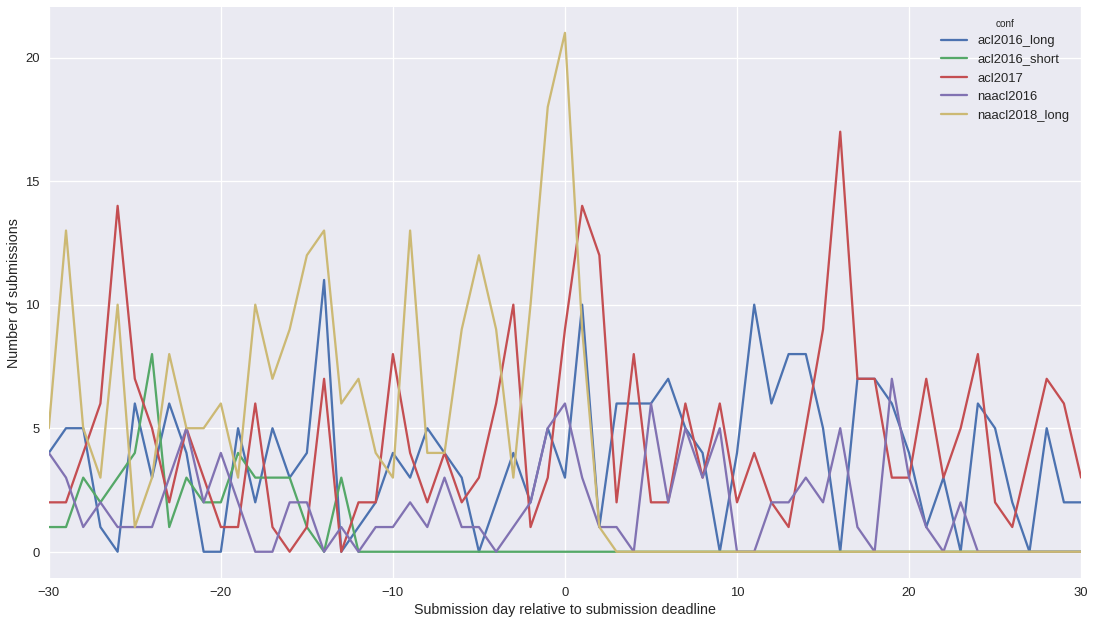

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax = sns.tsplot(time='day', value='count', unit=[1]*61, condition='conf', data=grouped, ax=ax)
ax.set_xlabel('Submission day relative to submission deadline')
ax.set_ylabel('Number of submissions')